# Paramétrage de l'environnement de travail et import des packages

In [1]:
import sys
from pathlib import Path

In [2]:
ROOT = Path.cwd().parents[0]

RAW_DATA = ROOT / "01_data" / "01_raw"
PROCESSED_DATA = ROOT / "01_data" / "02_processed"

NOTEBOOK = ROOT / "02_notebooks"

FONCTIONS = ROOT / "03_fonctions"

%load_ext autoreload
%autoreload 2
sys.path.append(str(ROOT / "03_fonctions"))

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from statistics import mean
from cheat_tools.data_manipulation import missing_percentage, multi_astype
from cheat_tools.data_visualization import afficher_heatmap_correlation, plot_kde_multivariables_grid
from cheat_tools.stat_tests import analyser_dependance_khi2, analyser_dependance_mannwhitney
from cheat_tools.econometrics_tools import box_tidwell_test, trv_logit, hosmer_lemeshow_test, vif_logit, spline_test_multi, add_centered_quadratic, add_centered_vars



# Global

**Informations globales sur le jeu de données**

In [4]:
data_housing = pd.read_csv(PROCESSED_DATA / "02_eda" / "housing_data_eda_processed.csv",
                           dtype={'id_annonce':"object"})


In [5]:
data_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26647 entries, 0 to 26646
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id_annonce                      26647 non-null  object 
 1   code_insee                      26647 non-null  object 
 2   approximate_latitude            26647 non-null  float64
 3   approximate_longitude           26647 non-null  float64
 4   size                            26478 non-null  float64
 5   nb_rooms                        26505 non-null  float64
 6   nb_photos                       26647 non-null  float64
 7   population                      26445 non-null  float64
 8   nb_menages_fiscaux              26316 non-null  float64
 9   revenu_median                   26316 non-null  float64
 10  nb_actes_delinquants            26421 non-null  float64
 11  nb_lits_tourisme                26421 non-null  float64
 12  densite_services_rayon          

In [6]:
data_housing.describe()

,approximate_latitude,approximate_longitude,size,nb_rooms,nb_photos,population,nb_menages_fiscaux,revenu_median,nb_actes_delinquants,nb_lits_tourisme,densite_services_rayon,target
count,26647.000000,26647.000000,26478.000000,26505.000000,26647.000000,26445.000000,26316.000000,26316.000000,26421.000000,26421.000000,26647.000000,26647.000000
mean,46.560133,2.653711,124.748725,4.380117,8.470034,45363.082851,20417.412867,24194.437604,3640.420423,612.053102,152.187188,0.346155
std,2.358993,2.584023,70.909756,2.212467,4.505727,81954.828111,36762.248374,5199.219277,7281.908925,1453.105525,256.370255,0.475752
min,41.374436,-4.718490,10.000000,1.000000,1.000000,14.000000,41.000000,13460.000000,0.000000,0.000000,0.000000,0.000000
25%,43.896695,1.198593,72.000000,3.000000,5.000000,2613.000000,1200.750000,20970.000000,62.000000,0.000000,12.000000,0.000000
50%,46.985814,2.385489,110.000000,4.000000,8.000000,12096.000000,5562.000000,22870.000000,654.000000,0.000000,47.000000,0.000000
75%,48.844479,4.683550,185.000000,5.000000,10.000000,49104.000000,22023.000000,25810.000000,3482.000000,557.000000,164.000000,1.000000
max,51.046009,9.503198,1420.000000,27.000000,50.000000,504078.000000,222023.000000,55340.000000,43378.000000,16734.000000,1524.000000,1.000000


In [19]:
missing_percentage(data_housing).sort_values(by=0, ascending=False).head(13)


,features,0
10,nb_actes_delinquants,0.01
14,position_commune_unite_urbaine,0.01
19,taille_agglomeration,0.01
18,taille_pole_et_couronne,0.01
4,size,0.01
5,nb_rooms,0.01
17,type_unite_urbaine,0.01
7,population,0.01
8,nb_menages_fiscaux,0.01
9,revenu_median,0.01


In [20]:
data_housing.head()

,id_annonce,code_insee,approximate_latitude,approximate_longitude,size,nb_rooms,nb_photos,population,nb_menages_fiscaux,revenu_median,...,nb_lits_tourisme,densite_services_rayon,type_rural_urbain,position_commune_unite_urbaine,property_type,type_degre_densite,type_unite_urbaine,taille_pole_et_couronne,taille_agglomeration,target
0,11541,01263,46.083952,4.762737,117.0,4.0,8.0,3792.0,1651.0,25970.0,...,0.0,12.0,Urbain,Banlieue,maison,Ceintures urbaines,Agglomération inter-départementale,Hors Attraction Villes,20k - 50k hab,0
1,09207,06004,43.587061,7.115609,185.0,3.0,6.0,75130.0,40649.0,24410.0,...,2958.0,223.0,Urbain,Banlieue,appartement,Grands centres urbains,Agglomération intra-départementale,Aire 200k - 700k,200k - 2M hab,0
2,15840,76351,49.500023,0.137997,64.0,3.0,6.0,166058.0,77021.0,20180.0,...,1719.0,189.0,Urbain,Centre,appartement,Grands centres urbains,Agglomération intra-départementale,Aire 200k - 700k,200k - 2M hab,0
3,03543,34147,43.470415,3.217742,107.0,5.0,10.0,3478.0,1422.0,21650.0,...,0.0,18.0,Rural,Centre,maison,Bourgs ruraux,Agglomération intra-départementale,Aire 50k - 200k,2k - 5k hab,0
4,34900,24055,45.318143,0.600697,266.0,9.0,8.0,780.0,304.0,20560.0,...,0.0,3.0,Rural,Hors unité urbaine,maison,Rural à habitat dispersé,Commune hors unité urbaine du département,Hors Attraction Villes,Rural / Hors Agglo,0


# EDA & Statistiques

### Avant l'ajout des variables ratios

**Matrice de corrélation**

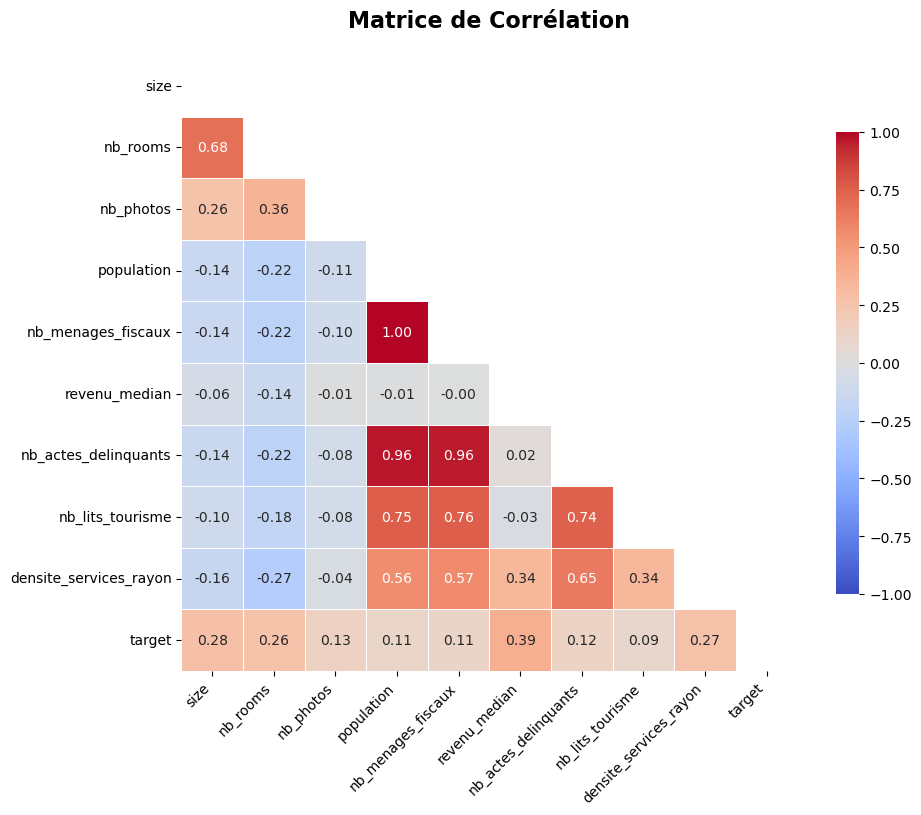

In [21]:
variables_interet = ["size","nb_rooms","nb_photos",
                     "population","nb_menages_fiscaux","revenu_median",
                     "nb_actes_delinquants","nb_lits_tourisme","densite_services_rayon",
                     "target"]

afficher_heatmap_correlation(
    data_housing,
    variables_interet
)

**Test de Mann-Whitney**

In [22]:
variables_interet = ["size","nb_rooms","nb_photos",
                     "population","nb_menages_fiscaux","revenu_median",
                     "nb_actes_delinquants","nb_lits_tourisme","densite_services_rayon"]

analyser_dependance_mannwhitney(
    data_housing,
    "target",
    variables_interet
)

--- Analyse Mann-Whitney (Target Binaire : 'target') ---
--- Comparaison : Groupe '0' vs Groupe '1' ---


,Variable,P-value,Différence Significative,Taille Effet (r),Direction Effet,U Stat
0,revenu_median,< 0.001,OUI,0.4540,Positif,42892203.0
1,size,< 0.001,OUI,0.3177,Positif,54204306.5
2,nb_rooms,< 0.001,OUI,0.2959,Positif,55972570.0
3,densite_services_rayon,< 0.001,OUI,0.2890,Positif,57134340.0
4,nb_actes_delinquants,< 0.001,OUI,0.2629,Positif,58298724.0
5,nb_menages_fiscaux,< 0.001,OUI,0.2561,Positif,58431481.0
6,population,< 0.001,OUI,0.2559,Positif,58936890.0
7,nb_lits_tourisme,< 0.001,OUI,0.2149,Positif,62097451.5
8,nb_photos,< 0.001,OUI,0.1432,Positif,68851167.5


**Test de Khi2**

In [13]:
variables_interet = ["position_commune_unite_urbaine","taille_agglomeration","type_unite_urbaine",
                     "taille_pole_et_couronne","type_degre_densite","type_rural_urbain","property_type"]

analyser_dependance_khi2(
    data_housing,
    "target",
    variables_interet
    )

--- Analyse de dépendance (Khi-deux) avec la cible : 'target' ---


,Variable,P-value,Dépendance Significative,V de Cramer,Chi2 Stat
0,taille_agglomeration,< 0.001,OUI,0.3154,2628.36
1,taille_pole_et_couronne,< 0.001,OUI,0.3020,2410.15
2,type_unite_urbaine,< 0.001,OUI,0.2718,1951.62
3,type_degre_densite,< 0.001,OUI,0.2477,1620.91
4,position_commune_unite_urbaine,< 0.001,OUI,0.1929,983.11
5,type_rural_urbain,< 0.001,OUI,0.1864,917.60
6,property_type,< 0.001,OUI,0.1356,490.01


### Après l'ajout de variables ratios

**Création des variables**

In [14]:
# Taux de criminalté pour 1000 habitants
data_housing = data_housing.eval('taux_criminalite_1000 = (nb_actes_delinquants/population)*1000')
data_housing["taux_criminalite_1000"] = data_housing["taux_criminalite_1000"].clip(0,300)


# Taille moyenne d'un ménage fiscal (cette variable ne sera pas conservé car peu de pouvoir discrimant)
data_housing = data_housing.eval('taille_moyenne_menage = population / nb_menages_fiscaux')

# Taux de pression touristique pour 1000 habitants
data_housing = data_housing.eval('taux_pression_touristique_1000 = (nb_lits_tourisme / population)*1000')
data_housing["est_attrait_touristique"] = np.where(data_housing["taux_pression_touristique_1000"]>10,1,0)

**Matrice de corrélation**

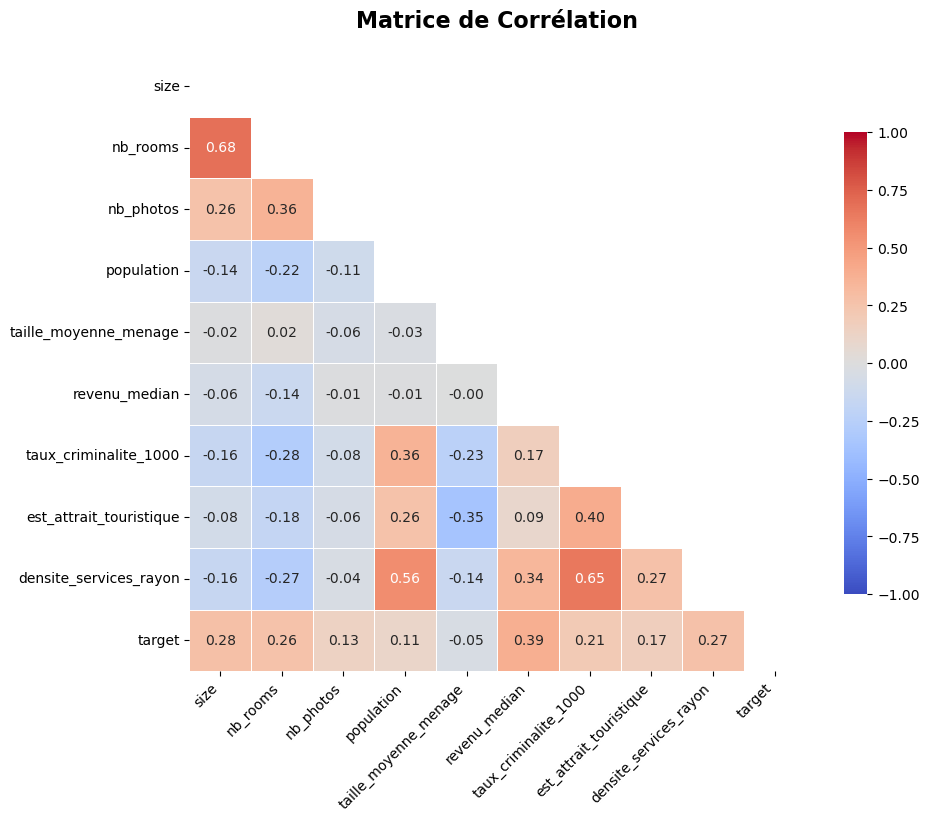

In [15]:
variables_interet = ["size","nb_rooms","nb_photos",
                     "population","taille_moyenne_menage","revenu_median",
                     "taux_criminalite_1000","est_attrait_touristique","densite_services_rayon",
                     "target"]

afficher_heatmap_correlation(
    data_housing,
    variables_interet
)

**Analyse de la distribution de 'taux_de_criminalite_1000' et 'taille_moyenne_menage' en fonction de la variable cible**

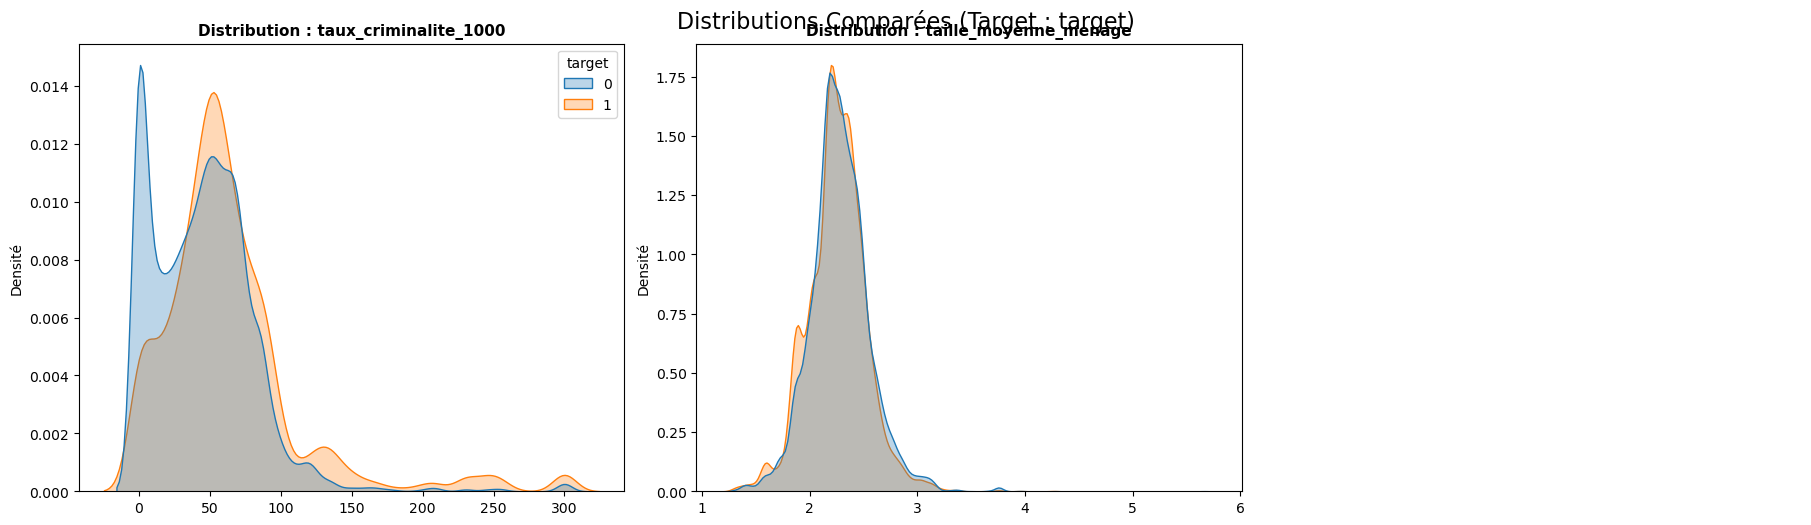

In [16]:
variables_interet = ["taux_criminalite_1000","taille_moyenne_menage"]

plot_kde_multivariables_grid(
    data_housing,
    variables_interet,
    "target"
)

**Test de Mann-Whitney**

In [17]:
variables_interet = ["size","nb_rooms","nb_photos",
                     "population","taille_moyenne_menage","revenu_median",
                     "taux_criminalite_1000","densite_services_rayon"]

analyser_dependance_mannwhitney(
    data_housing,
    "target",
    variables_interet
)

--- Analyse Mann-Whitney (Target Binaire : 'target') ---
--- Comparaison : Groupe '0' vs Groupe '1' ---


,Variable,P-value,Différence Significative,Taille Effet (r),Direction Effet,U Stat
0,revenu_median,< 0.001,OUI,0.4540,Positif,42892203.0
1,size,< 0.001,OUI,0.3177,Positif,54204306.5
2,nb_rooms,< 0.001,OUI,0.2959,Positif,55972570.0
3,densite_services_rayon,< 0.001,OUI,0.2890,Positif,57134340.0
4,population,< 0.001,OUI,0.2559,Positif,58936890.0
5,taux_criminalite_1000,< 0.001,OUI,0.2272,Positif,61112293.0
6,nb_photos,< 0.001,OUI,0.1432,Positif,68851167.5
7,taille_moyenne_menage,< 0.001,OUI,0.0426,Négatif,81874798.5


In [ ]:
# variables créées et retenues pour la suite
    # --> taux_criminalite_1000
    # --> est_attrait_touristique
    # --> taille_agglomeration

# variables non retenues
    # --> position_commune_unite_urbaine
    # --> type_degre_densite
    # --> type_unite_urbaine
    # --> taille_pole_et_couronne
    # --> taille_moyenne_menage
    # --> taux_pression_touristique

# Analyse économétrique

### Premier modèle

**Selection des variables d'interet pour le modèle économétrique**

In [19]:
data_econometrie = data_housing.drop(["id_annonce","code_insee","nb_menages_fiscaux",
                                      "nb_actes_delinquants","nb_lits_tourisme","type_rural_urbain",
                                      "position_commune_unite_urbaine","type_degre_densite","taille_pole_et_couronne",
                                      "taille_moyenne_menage","taux_pression_touristique_1000","type_unite_urbaine"],
                                      axis=1).dropna()

multi_astype(data_econometrie,["property_type","taille_agglomeration"],"category")

data_econometrie.info()

property_type: object → category
taille_agglomeration: object → category

Succès: 2/2
<class 'pandas.core.frame.DataFrame'>
Index: 26026 entries, 0 to 26646
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   approximate_latitude     26026 non-null  float64 
 1   approximate_longitude    26026 non-null  float64 
 2   size                     26026 non-null  float64 
 3   nb_rooms                 26026 non-null  float64 
 4   nb_photos                26026 non-null  float64 
 5   population               26026 non-null  float64 
 6   revenu_median            26026 non-null  float64 
 7   densite_services_rayon   26026 non-null  float64 
 8   property_type            26026 non-null  category
 9   taille_agglomeration     26026 non-null  category
 10  target                   26026 non-null  int64   
 11  taux_criminalite_1000    26026 non-null  float64 
 12  est_attrait_touristique  26026 non-

**Mise à l'échelle des données**

In [20]:
X_num = data_econometrie.drop(["target","property_type","taille_agglomeration",
                               "est_attrait_touristique"], axis = 1)

X_num_scaled = pd.DataFrame(StandardScaler().fit_transform(X_num),
                        columns=X_num.columns,
                        index=X_num.index)

X_cat = data_econometrie[["property_type","taille_agglomeration","est_attrait_touristique"]]

Y = data_econometrie["target"]


data_econometrie_scaled = pd.concat([X_cat,X_num_scaled,Y], axis = 1)

**Création & Résulats du modèle**

In [21]:
equation = "target ~ approximate_latitude + approximate_longitude + size + nb_rooms + nb_photos + population + revenu_median + taux_criminalite_1000 + densite_services_rayon + est_attrait_touristique + C(property_type, Treatment(reference='appartement')) + C(taille_agglomeration, Treatment(reference='200k - 2M hab'))"

logit = smf.logit(equation,data_econometrie_scaled).fit()

print(logit.summary2())

Optimization terminated successfully.
         Current function value: 0.406423
         Iterations 7
                                                           Results: Logit
Model:                                     Logit                                  Method:                                 MLE       
Dependent Variable:                        target                                 Pseudo R-squared:                       0.372     
Date:                                      2026-02-07 23:36                       AIC:                                    21197.1172
No. Observations:                          26026                                  BIC:                                    21368.6211
Df Model:                                  20                                     Log-Likelihood:                         -10578.   
Df Residuals:                              26005                                  LL-Null:                                -16832.   
Converged:                

**Test VIF**

In [22]:
vif_logit(logit).head(10)

,variable,VIF
0,"C(property_type, Treatment(reference='appartem...",3.201447
1,densite_services_rayon,3.073390
2,nb_rooms,2.476436
3,taux_criminalite_1000,2.403942
4,"C(taille_agglomeration, Treatment(reference='2...",2.206443
5,"C(taille_agglomeration, Treatment(reference='2...",2.045865
6,size,1.931936
7,population,1.804838
8,est_attrait_touristique,1.663164
9,approximate_latitude,1.641854


**Test de Box Tidwell**

In [23]:
box_tidwell_test(
    data_econometrie,
    "target",
    ["size","nb_rooms","nb_photos","revenu_median","population","taux_criminalite_1000"],
    ["est_attrait_touristique","property_type","taille_agglomeration"]
)

,Coef.,Std.Err.,z,p_value,transformation_necessaire
size,0.000827,1.031317e-03,0.801870,4.226283e-01,False
nb_rooms,-1.063900,3.538230e-02,-30.068713,1.243219e-198,True
nb_photos,0.100103,1.065944e-02,9.391046,5.940734e-21,True
revenu_median,-0.000461,2.737040e-05,-16.836291,1.322723e-63,True
population,-0.000009,4.899855e-07,-19.001874,1.645621e-80,True
taux_criminalite_1000,-0.006547,1.018756e-03,-6.425977,1.310251e-10,True


**Analyse des splines pour voir quelles transformations appliquer sur les variables**

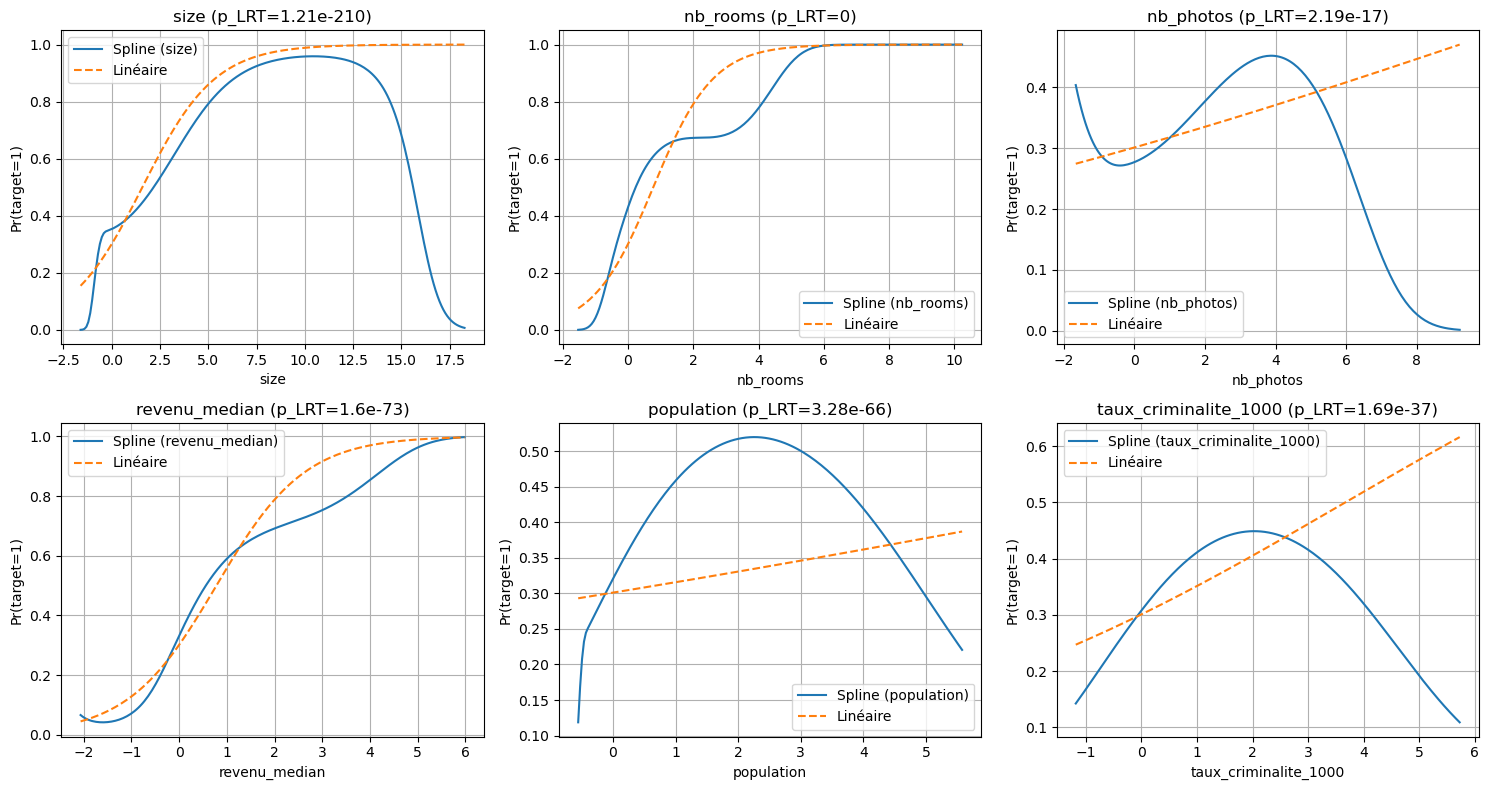

In [24]:
var_a_tester = ["size","nb_rooms","nb_photos","revenu_median","population","taux_criminalite_1000"]

res_spline_size = spline_test_multi(
    df=data_econometrie_scaled,
    formula_base=equation,
    vars_list=var_a_tester,
    df_spline=4,
    at="mean",
    plot=True,
    alpha=0.05
)

In [25]:
# Transformations à appliquer 
    # --> size : quadratique
    # --> nb_rooms : bins
    # --> nb_photos : quadratique
    # --> revenu_median : logarithme
    # --> population : quadratique
    # --> taux_criminalite_1000 : quadratique

### Deuxième modèle

**Feature engineering**

In [26]:
# Centrage des variables
add_centered_vars(
    data_econometrie,
    ["size","taux_criminalite_1000","population","nb_photos"]
)

# Transformations quadratiques ("size","quadrattaux_criminalite_1000ique","population","nb_photos")
add_centered_quadratic(
    data_econometrie,
    ["size","taux_criminalite_1000","population","nb_photos"]
)

# Binarisation (bins)
conditions = [
    data_econometrie["nb_rooms"].between(0,2),
    data_econometrie["nb_rooms"]==3,
    data_econometrie["nb_rooms"]==4,
    data_econometrie["nb_rooms"]>4
    ]

resultats = ["0-2","3","4","5+"]

data_econometrie["nb_rooms_bins"] = np.select(conditions,resultats)

# Transformation logarithmique (revenu_median)
data_econometrie["revenu_median_log"] = np.log(data_econometrie["revenu_median"])

Variables centrées créées :
  - size  ->  size_c
  - taux_criminalite_1000  ->  taux_criminalite_1000_c
  - population  ->  population_c
  - nb_photos  ->  nb_photos_c
Variables transformées (quadratique centrée) :
  - size  ->  size_2_c
  - taux_criminalite_1000  ->  taux_criminalite_1000_2_c
  - population  ->  population_2_c
  - nb_photos  ->  nb_photos_2_c


**Mise à l'échelle des données**

In [27]:
X_num = data_econometrie.drop(["target","property_type","taille_agglomeration",
                               "size","nb_rooms","nb_photos",
                               "population","revenu_median","taux_criminalite_1000",
                               "est_attrait_touristique","nb_rooms_bins"], axis = 1)

X_num_scaled = pd.DataFrame(StandardScaler().fit_transform(X_num),
                        columns=X_num.columns,
                        index=X_num.index)

X_cat = data_econometrie[["property_type","taille_agglomeration","est_attrait_touristique","nb_rooms_bins"]]

Y = data_econometrie["target"]


data_econometrie_scaled = pd.concat([X_cat,X_num_scaled,Y], axis = 1)

**Création & Résultats du deuxième modèle**

In [28]:
equation = "target ~ approximate_latitude + approximate_longitude + size_c + size_2_c + C(nb_rooms_bins,Treatment(reference='5+')) + nb_photos_c + nb_photos_2_c + population_c + population_2_c + revenu_median_log + taux_criminalite_1000_c + taux_criminalite_1000_2_c + densite_services_rayon + est_attrait_touristique + C(property_type, Treatment(reference='appartement')) + C(taille_agglomeration, Treatment(reference='200k - 2M hab'))"

logit2 = smf.logit(equation,data_econometrie_scaled).fit()

print(logit2.summary2())

Optimization terminated successfully.
         Current function value: 0.370420
         Iterations 7
                                                           Results: Logit
Model:                                     Logit                                  Method:                                 MLE       
Dependent Variable:                        target                                 Pseudo R-squared:                       0.427     
Date:                                      2026-02-07 23:36                       AIC:                                    19335.0855
No. Observations:                          26026                                  BIC:                                    19555.5905
Df Model:                                  26                                     Log-Likelihood:                         -9640.5   
Df Residuals:                              25999                                  LL-Null:                                -16832.   
Converged:                

**Test VIF**

In [29]:
vif_logit(logit2)

,variable,VIF
0,population_c,9.245168
1,population_2_c,5.940172
2,taux_criminalite_1000_c,5.782368
3,taux_criminalite_1000_2_c,3.606560
4,densite_services_rayon,3.429103
5,"C(taille_agglomeration, Treatment(reference='2...",3.178227
6,"C(property_type, Treatment(reference='appartem...",3.048747
7,"C(taille_agglomeration, Treatment(reference='2...",2.701287
8,"C(nb_rooms_bins, Treatment(reference='5+'))[T....",1.938739
9,size_c,1.848946


**Interpétation des effets marginaux du modèle**

In [30]:
print(logit2.get_margeff(at='overall').summary())

        Logit Marginal Effects       
Dep. Variable:                 target
Method:                          dydx
At:                           overall
                                                                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
C(nb_rooms_bins, Treatment(reference='5+'))[T.0-2]                                     -0.5219      0.011    -49.363      0.000      -0.543      -0.501
C(nb_rooms_bins, Treatment(reference='5+'))[T.3]                                       -0.2360      0.008    -30.140      0.000      -0.251      -0.221
C(nb_rooms_bins, Treatment(reference='5+'))[T.4]                                       -0.0996      0.006    -15.407      0.000      -0.112      -0.087
C(property_type, Treatment(reference='appartement'))[T.autre]                           

### 1. Caractéristiques intrinsèques du bien

**Nombre de pièces (référence = 5+ pièces)**  
- 0–2 pièces : -52 points de probabilité  
- 3 pièces : -23 points  
- 4 pièces : -10 points  

Le nombre de pièces est un déterminant majeur : plus un bien est grand, plus la probabilité d’être dans la classe haute augmente.

**Surface (effet non linéaire)**  
- Effet linéaire positif  
- Effet quadratique significatif  

La probabilité augmente avec la surface, avec une dynamique non linéaire cohérente économiquement.

**Type de bien (référence = appartement)**  
- Maison : +2,9 points  
- Autre : +11,9 points  

Les maisons et biens atypiques présentent une probabilité plus élevée d’être dans la classe haute.

---

### 2. Localisation et structure urbaine

**Taille d’agglomération (référence = 200k–2M habitants)**  
- Paris (agglo) : +18 points  
- Zones rurales : -7,5 points  
- Agglomérations intermédiaires : effets négatifs modérés  

La localisation est fortement structurante. L’effet Paris est particulièrement marqué.

**Latitude / Longitude**  
Effets significatifs traduisant une hétérogénéité géographique du marché.

---

### 3. Contexte socio-économique

**Revenu médian (log)**  
+16 points → variable territoriale la plus déterminante.

**Population (effet non linéaire)**  
Effet positif puis décroissant : les grandes villes augmentent la probabilité, mais avec un rendement marginal décroissant.

**Taux de criminalité (effet non linéaire)**  
Effet positif modéré, possiblement lié à la corrélation entre zones dynamiques et intensité urbaine.

**Densité de services**  
+4,4 points → accessibilité et équipements jouent un rôle significatif.

**Attractivité touristique**  
+10,8 points → forte prime territoriale liée au tourisme.

---

## Lecture globale

Le modèle met en évidence trois dimensions majeures :

1. **Caractéristiques structurelles du bien** (surface, pièces)
2. **Niveau socio-économique local** (revenu médian)
3. **Attractivité territoriale** (Paris, tourisme, services)

Les effets sont globalement très significatifs et économiquement cohérents.  
Cette étape fournit un socle explicatif robuste avant la phase de modélisation prédictive (Machine Learning).
